In [6]:
import numpy as np;
from visualize import plot_2, plot_3, plot_3d, plot_6;
from load_dataset import load_mnist_test, load_mnist_train;
from conduct_svm import svm;
from conduct_csc import nn_csc, csc, par_csc, par_nn_csc;
from pickless import output;
from pooling import forward;
from sporco import plot, util;
from sporco.admm import cbpdn
from conduct_svm import *;

In [36]:
def make_option():
    opt = {};
    # 訓練画像の枚数
    opt['train_amount'] = 500;
    # テスト画像の枚数
    opt['test_amount'] = 1000;
    # フィルタのサイズ
    opt['d_size'] = [(5, 5, 1, 1, 16), (5, 5, 16, 6)];
    # スパースの尺度
    opt['lmbda'] = [0.05, 0.025];
    # 繰り返し回数
    opt['Iter'] = [400, 400];
    # NMFによる錐制約部分空間法における基底の数
    opt['d_num'] = 16;
    # PCAによる包括凸錐による部分空間法における累積寄与率のリスト・パラメータ
    opt["ratios"] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999];
    opt["params"] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0];
    return opt;

In [37]:
opt = make_option();
train_data, train_label = load_mnist_train(opt["train_amount"]);
test_data, test_label = load_mnist_test(opt["test_amount"]);
train_data = np.expand_dims(train_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data, -1);

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


load_mnist_train: return following shape arrays
imgs: (500, 32, 32)
labels: (500,)
load_mnist_test: return following shape arrays
imgs: (1000, 32, 32)
labels: (1000,)


/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [13]:
train_data.shape

(32, 32, 1, 500)

### 学習用データセットで畳み込み辞書学習
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.01e+04  6.34e+03  7.54e+04  2.57e-07  7.84e-01  6.95e-01  3.00e+00  1.55e-01  4.16e-01  1.00e+01
   1  1.08e+04  6.76e+03  8.04e+04  3.43e-07  3.13e-01  1.27e+00  3.00e+00  1.29e-01  2.55e-01  1.00e+01
   2  8.93e+03  4.05e+03  9.77e+04  1.98e-07  2.11e-01  6.08e-01  3.00e+00  9.09e-02  1.70e-01  1.00e+01
   3  7.94e+03  3.89e+03  8.09e+04  3.47e-07  1.53e-01  7.86e-01  3.00e+00  8.71e-02  7.58e-02  1.00e+01
   4  7.52e+03  3.71e+03  7.63e+04  3.20e-07  1.24e-01  3.87e-01  3.00e+00  6.40e-02  1.80e-01  1.00e+01
   5  7.00e+03  3.47e+03  7.06e+04  3.20e-07  8.46e-02  3.46e-01  3.00e+00  5.35e-02  1.28e-01  1.00e+01
   6  6.73e+03  3.31e+03  6.86e+04  2.81e-07  7.42e-02  2.86e-01  3.00e+00  4.37e-02  7.34e-02  1.00e+01
   7  6.46e+

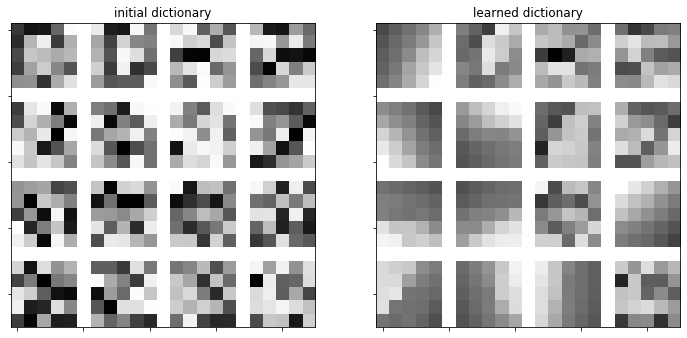

In [14]:
# 学習用データセットで辞書学習
print("### 学習用データセットで畳み込み辞書学習");

print("第１層目:フォワードパスの計算中...");
d0, D0, coef0_ = nn_csc(input_ = np.float32(train_data), d_size = opt['d_size'][0], lmbda = opt['lmbda'][0], Iter = opt['Iter'][0], visualize = True);
print("第１層目:プーリング中...");
coef0 = forward(coef0_.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

print("第２層目:フォワードパスの計算中...");
d1, D1, coef1 = nn_csc(input_ = np.float32(coef0), d_size = opt['d_size'][1], lmbda = opt['lmbda'][1], Iter = opt['Iter'][1], visualize = False);
print("第２層目:プーリング中...");
coef2 = forward(coef1.squeeze().transpose(2,3,0,1), 2, 2, 2);
# output(opt, D0, coef0, D1, coef1);

<IPython.core.display.Javascript object>


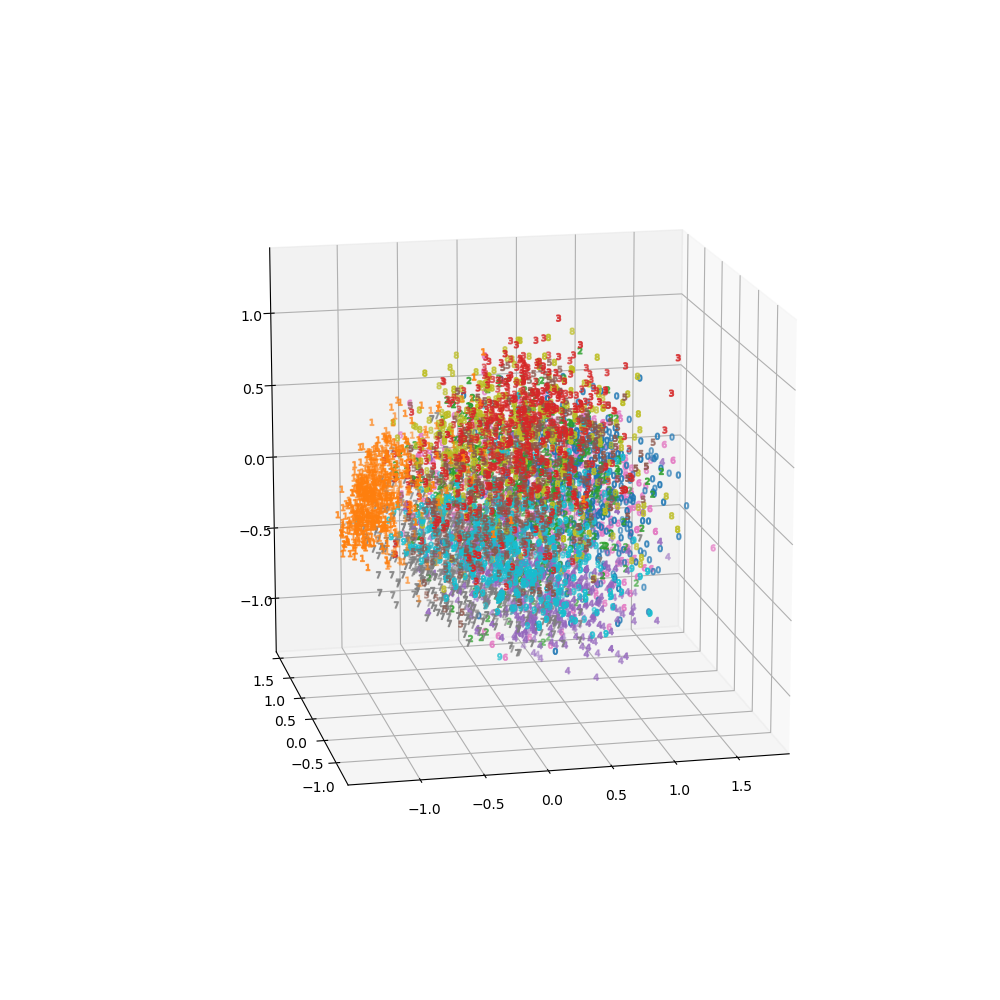

In [5]:
#visualize the last output
%matplotlib notebook
from visualize import plot_3d
plot_3d(coef2.reshape(coef2.shape[0], -1), train_label)

<IPython.core.display.Javascript object>


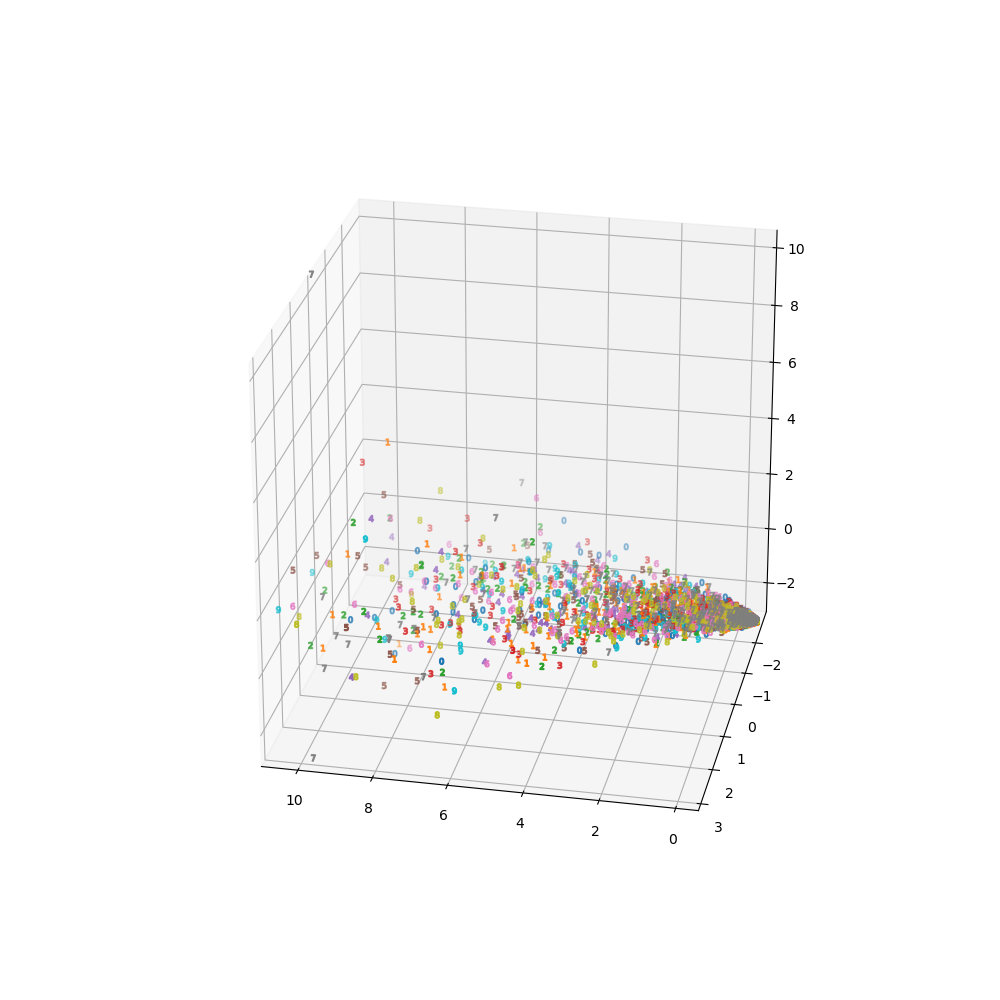

In [7]:
#visualize the 1st layer output (no pooling)
%matplotlib notebook
from visualize import plot_3d
plot_3d(coef0_.squeeze().transpose(3, 0, 1, 2).reshape(opt["train_amount"], -1), train_label)

<IPython.core.display.Javascript object>


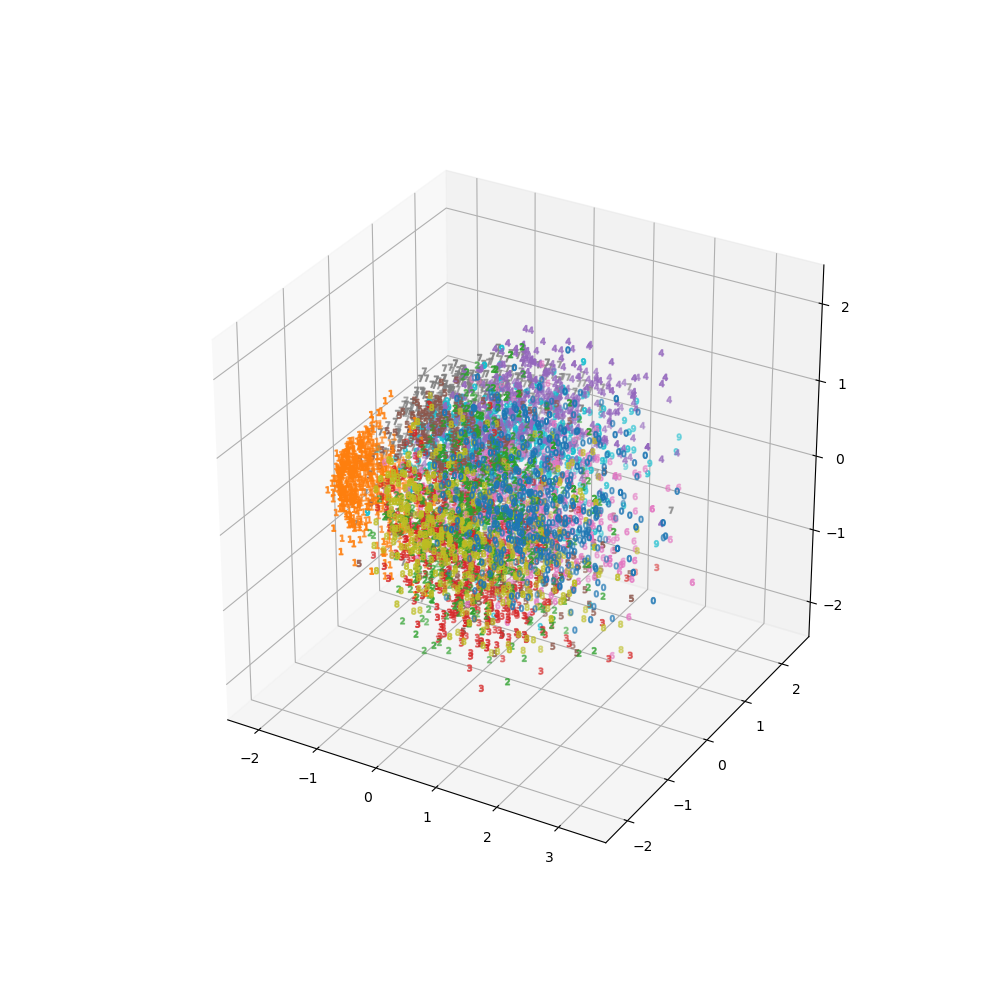

In [12]:
#visualize the 1st layer output (enable pooling)
%matplotlib notebook
from visualize import plot_3d
plot_3d(coef0.transpose(3, 0, 1, 2).reshape(opt["train_amount"], -1), train_label)

<IPython.core.display.Javascript object>


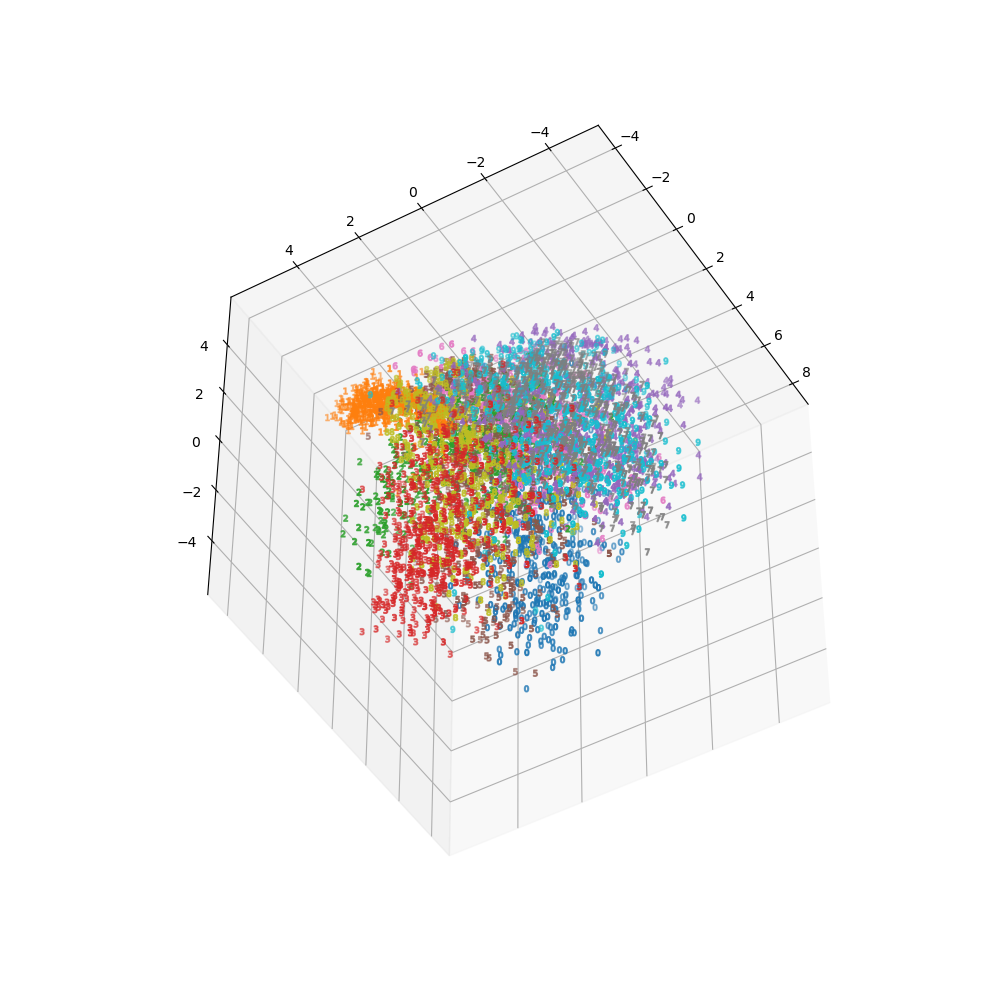

In [15]:
# visualize the original images
%matplotlib notebook
plot_3d(train_data.reshape(train_data.shape[0]*train_data.shape[1]*train_data.shape[2], -1).T, train_label)

In [15]:
# 学習用の非負特徴量(data_num, data_dim)
train_feature = coef2.reshape(opt["train_amount"], -1)

In [17]:
# テスト用データセットの係数算出
print("### テスト用データセットの係数算出 ###");

test_opt0 = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': opt["Iter"][0], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
b0 = cbpdn.ConvBPDN(np.float32(D0), np.float32(test_data), opt["lmbda"][0], test_opt0);
print("第１層目:フォワードパスの計算中...");
test_coef0 = b0.solve();
print("第１層目:プーリング中...");
test_coef0 = forward(test_coef0.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);


test_opt1 = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': opt["Iter"][1], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
test_coef0 = np.expand_dims(test_coef0, -1);
b1 = cbpdn.ConvBPDN(np.float32(D1.squeeze()), np.float32(test_coef0), opt["lmbda"][1], test_opt1);
print("第２層目:フォワードパスの計算中...");
test_coef1 = b1.solve();
print("第２層目:プーリング中...");
test_coef1 = forward(test_coef1.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

test_feature = test_coef1.transpose(3, 0, 1, 2).reshape(opt["test_amount"], -1);
print("test_feature:", test_feature.shape);

### テスト用データセットの係数算出 ###
第１層目:フォワードパスの計算中...
第１層目:プーリング中...
第２層目:フォワードパスの計算中...
第２層目:プーリング中...
test_feature: (1000, 384)


In [18]:
# SVMによる分類
clf = train_svm(train_feature, train_label);
test_precision = test_svm(clf, test_feature, test_label);

Train precision:  0.986
Test precision:  0.824


In [19]:
# 錘を作るための関数郡
from sklearn.decomposition import NMF
def create_cone_NMF(feature, num):
    nmf = NMF(n_components=num);
    W = nmf.fit_transform(feature);
    H = nmf.components_;
    return nmf, H, W;

def restore_from_cone_NMF(feature, nmf):
    restore = nmf.inverse_transform(nmf.transform(feature));
    return restore;

In [20]:
# 学習データの錘を作成
# H: 錐の基底ベクトル
# W: 非負値結合係数
# nmf: NMFクラス

NMFs = [];
Hs = [];
Ws = [];
for i in range(10):
    print(str(i)+"番目のクラスの錐を作成中...");
    nmf, H, W = create_cone_NMF(train_feature[train_label == i], opt["d_num"]);
    NMFs.append(nmf);
    Hs.append(H);
    Ws.append(W);

0番目のクラスの錐を作成中...
1番目のクラスの錐を作成中...
2番目のクラスの錐を作成中...
3番目のクラスの錐を作成中...
4番目のクラスの錐を作成中...
5番目のクラスの錐を作成中...
6番目のクラスの錐を作成中...
7番目のクラスの錐を作成中...
8番目のクラスの錐を作成中...
9番目のクラスの錐を作成中...


In [21]:
# テストデータを錐へ射影
# restore: 射影したベクトル
restores = [];
for i in range(10):
    print(str(i)+"番目のクラスの錐で入力を再現中...")
    temp = restore_from_cone_NMF(test_feature, NMFs[i]);
    restores.append(temp);

0番目のクラスの錐で入力を再現中...
1番目のクラスの錐で入力を再現中...
2番目のクラスの錐で入力を再現中...
3番目のクラスの錐で入力を再現中...
4番目のクラスの錐で入力を再現中...
5番目のクラスの錐で入力を再現中...
6番目のクラスの錐で入力を再現中...
7番目のクラスの錐で入力を再現中...
8番目のクラスの錐で入力を再現中...
9番目のクラスの錐で入力を再現中...


In [22]:
from sklearn.metrics.pairwise import cosine_similarity;
CosArray = [];
for i in range(10):
    cos_array = cosine_similarity(test_feature, restores[i]);
    CosArray.append(np.diag(cos_array));
CosArray = np.array(CosArray);
predict_label = np.argmax(CosArray, axis = 0);
precision = sum(predict_label == test_label)/test_label.shape[0];
print('Test precision: ', precision);

Test precision:  0.809


In [56]:
def NMF_Classifier(train_feature, train_label, test_feature, test_label, from_, to_):
    accuracy = []
    for h in range(from_, to_+1):
        NMFs = [];
        Hs = [];
        Ws = [];
        for i in range(10):
            #print(str(i)+"番目のクラスの錐を作成中...");
            nmf, H, W = create_cone_NMF(train_feature[train_label == i], h);
            NMFs.append(nmf);
            Hs.append(H);
            Ws.append(W);
        restores = [];
        for i in range(10):
            #print(str(i)+"番目のクラスの錐で入力を再現中...")
            temp = restore_from_cone_NMF(test_feature, NMFs[i]);
            restores.append(temp);
        CosArray = [];
        for i in range(10):
            cos_array = cosine_similarity(test_feature, restores[i]);
            CosArray.append(np.diag(cos_array));            
        CosArray = np.array(CosArray);
        predict_label = np.argmax(CosArray, axis = 0);
        precision = sum(predict_label == test_label)/test_label.shape[0];
        accuracy.append(precision);
        print("d_num="+str(h)+": Test precision: ", precision);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("# of basis");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.0, 1.0);
    ax.plot(accuracy);
    ax.set_title("Cone restricted subspace method by NMF");
    fig.savefig("result/nmf.png")

d_num=1: Test precision:  0.682
d_num=2: Test precision:  0.765
d_num=3: Test precision:  0.816
d_num=4: Test precision:  0.819
d_num=5: Test precision:  0.819
d_num=6: Test precision:  0.823
d_num=7: Test precision:  0.812
d_num=8: Test precision:  0.822
d_num=9: Test precision:  0.821
d_num=10: Test precision:  0.812
d_num=11: Test precision:  0.815
d_num=12: Test precision:  0.82
d_num=13: Test precision:  0.817
d_num=14: Test precision:  0.807
d_num=15: Test precision:  0.811
d_num=16: Test precision:  0.812


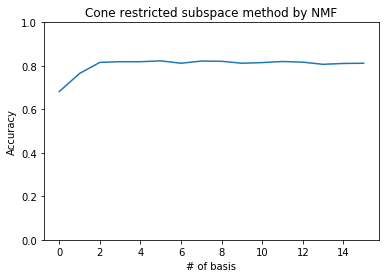

In [57]:
NMF_Classifier(train_feature, train_label, test_feature, test_label, 1, 16);

In [25]:
from sklearn.preprocessing import normalize
from sporco import prox
test_feature_norm = normalize(test_feature);

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/sporco/plot.py:673: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[[1.         0.27122221 0.47865438 0.3083248  0.43041737 0.36025109
  0.39219087 0.36849984 0.37647856 0.49993814 0.58928354 0.56964174
  0.49279133 0.36268037 0.53534961 0.54797296]
 [0.27122221 1.         0.28450723 0.26748151 0.40020037 0.44624153
  0.24463982 0.27923678 0.25716857 0.34183179 0.3003388  0.31382005
  0.39310872 0.32374776 0.27641216 0.40575477]
 [0.47865438 0.28450723 1.         0.2445762  0.33544819 0.39339254
  0.4442683  0.24700547 0.39784261 0.52808733 0.38952773 0.37624767
  0.58919089 0.50138707 0.48128287 0.62851754]
 [0.3083248  0.26748151 0.2445762  1.         0.35765261 0.15918842
  0.38285003 0.28569034 0.24139064 0.22694251 0.304791   0.27278807
  0.30674588 0.33542347 0.3701895  0.31203659]
 [0.43041737 0.40020037 0.33544819 0.35765261 1.         0.35182733
  0.50960019 0.49324359 0.37315598 0.32572745 0.34401914 0.38304029
  0.53177074 0.4447217  0.57984904 0.41984966]
 [0.36025109 0.44624153 0.39339254 0.15918842 0.35182733 1.
  0.15505184 0.3002306  0

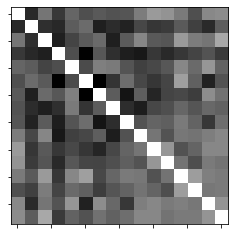

In [26]:
Hs[0].shape
H0 = normalize(Hs[0]);
corr_0 = H0.dot(H0.T);
plot.imview(corr_0);
print(corr_0);

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
param = 1.0;
ratio = 0.9;
# feature = normalize(np.random.uniform(0.0, 1.0, (500, 1024)));
feature = normalize(test_feature);
pca = PCA(n_components=ratio);
pca.fit(feature);
variance = pca.explained_variance_;
mean = pca.mean_;
basis = pca.components_;
cone_basis = [];
cnt = 0;
for i in variance:
    cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
    cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
    cnt=cnt+1;
cone_basis = np.array(cone_basis);

In [28]:
from scipy.optimize import nnls;

def create_cone_PCA(feature, param, ratio):
    feature = normalize(feature);
    pca = PCA(n_components=ratio);
    pca.fit(feature);
    variance = pca.explained_variance_;
    mean = pca.mean_;
    basis = pca.components_;
    cone_basis = [];
    cnt = 0;
    for i in variance:
        cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
        cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
        cnt=cnt+1;
    cone_basis = np.array(cone_basis);
    return cone_basis;

def restore_from_cone_PCA(cone_basis, feature):
    feature = list(feature);
    restore = [];
    for i in feature:
        x = np.array(nnls(cone_basis.T, i)[0]);
        restore.append(cone_basis.T.dot(x));
    restore = np.array(restore);
    return restore;

In [29]:
cone_basis = create_cone_PCA(train_feature, 1.0, 0.9);

In [30]:
feature = list(feature)
restore = [];
for i in feature:
    x = np.array(nnls(cone_basis.T, i)[0]);
    restore.append(cone_basis.T.dot(x));
restore = np.array(restore);
#x = nnls(cone_basis, feature);

In [33]:
from matplotlib import pyplot as plt
def PCA_Classifier(train_feature, train_label, test_feature, test_label, params, ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999]):
    fig = plot.figure();
    ax = fig.add_subplot(111);
    cmap = plt.get_cmap("tab10");
    ax.set_title("Cone restricted subspace method by Comprehensive cone");
    ax.set_xlabel("ratios");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.8, 1.0);
    cnt=0;
    for param in params:
        accuracy = [];
        print("the parameter of scaling : "+str(param))
        for ratio in ratios:
            Cones = [];

            for i in range(10):
                #print(str(i)+"番目のクラスの錐を作成中...");
                cone = create_cone_PCA(train_feature[train_label == i], param, ratio);
                Cones.append(cone);
            restores = [];
            for i in range(10):
                #print(str(i)+"番目のクラスの錐で入力を再現中...")
                temp = restore_from_cone_PCA(Cones[i], test_feature);
                restores.append(temp);
            CosArray = [];
            for i in range(10):
                cos_array = cosine_similarity(test_feature, restores[i]);
                CosArray.append(np.diag(cos_array));

            CosArray = np.array(CosArray);
            predict_label = np.argmax(CosArray, axis = 0);
            precision = sum(predict_label == test_label)/test_label.shape[0];
            print("ratio="+str(ratio)+": Test precision: ", precision);
            accuracy.append(precision);
        ax.plot(accuracy, label = "k="+str(param), color = cmap(cnt));
        cnt=cnt+1;
    ax.legend();
    fig.savefig("result/Comprehensive.png");

the parameter of scaling : 0.5
ratio=0.1: Test precision:  0.753
ratio=0.2: Test precision:  0.765
ratio=0.3: Test precision:  0.771
ratio=0.4: Test precision:  0.767
ratio=0.5: Test precision:  0.767
ratio=0.6: Test precision:  0.766
ratio=0.7: Test precision:  0.765
ratio=0.8: Test precision:  0.765
ratio=0.9: Test precision:  0.765
ratio=0.99: Test precision:  0.765
ratio=0.999: Test precision:  0.765
ratio=0.9999: Test precision:  0.765
the parameter of scaling : 1.0
ratio=0.1: Test precision:  0.766
ratio=0.2: Test precision:  0.788
ratio=0.3: Test precision:  0.8
ratio=0.4: Test precision:  0.796
ratio=0.5: Test precision:  0.797
ratio=0.6: Test precision:  0.795
ratio=0.7: Test precision:  0.793
ratio=0.8: Test precision:  0.793
ratio=0.9: Test precision:  0.793
ratio=0.99: Test precision:  0.793
ratio=0.999: Test precision:  0.793
ratio=0.9999: Test precision:  0.793
the parameter of scaling : 1.5
ratio=0.1: Test precision:  0.763
ratio=0.2: Test precision:  0.798
ratio=0.3: Te

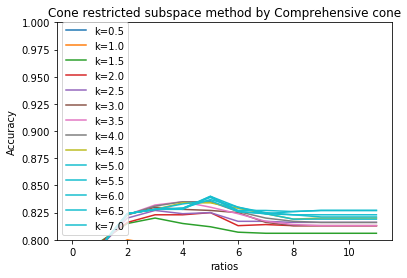

In [38]:
PCA_Classifier(train_feature, train_label, test_feature, test_label, opt["params"], opt["ratios"]);

ratio=0.1: Test precision:  0.764
ratio=0.2: Test precision:  0.793
ratio=0.3: Test precision:  0.824
ratio=0.4: Test precision:  0.828
ratio=0.5: Test precision:  0.829
ratio=0.6: Test precision:  0.84
ratio=0.7: Test precision:  0.83
ratio=0.8: Test precision:  0.825
ratio=0.9: Test precision:  0.823
ratio=0.99: Test precision:  0.823
ratio=0.999: Test precision:  0.823
ratio=0.9999: Test precision:  0.823


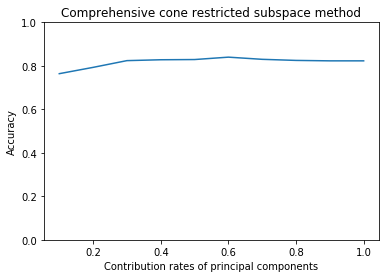

In [58]:
accuracy = [];
for ratio in opt["ratios"]:
    Cones = [];
    
    for i in range(10):
        cone =  create_cone_PCA(train_feature[train_label == i], 6.0, ratio);
        Cones.append(cone);
        
    restores = [];
    for i in range(10):
        temp = restore_from_cone_PCA(Cones[i], test_feature);
        restores.append(temp);
        
    CosArray = []
    for i in range(10):
        cos_array = cosine_similarity(test_feature, restores[i]);
        CosArray.append(np.diag(cos_array));
    
    CosArray = np.array(CosArray);
    predict_label = np.argmax(CosArray, axis = 0);
    precision = sum(predict_label == test_label)/test_label.shape[0];
    print("ratio="+str(ratio)+": Test precision: ", precision);
    accuracy.append(precision);
    
fig = plot.figure();
ax = fig.add_subplot(111);
ax.set_xlabel("Contribution rates of principal components");
ax.set_ylabel("Accuracy");
ax.set_ylim(0.0, 1.0);
# ax.plot(accuracy);
ax.set_title("Comprehensive cone restricted subspace method");
ax.plot(opt["ratios"], accuracy, label = "k="+str(param));
fig.savefig("result/pca_best.png")

In [53]:
ax.plot(opt["ratios"], accuracy, label = "k="+str(param));

'    \n    predict_label = np.argmax(CosArray, axis = 0);\n    precision = sum(preict_label == test_label)/test_label.shape[0];\n    print("ratio="+str(ratio)+": Test precision: ", precision);\n    accuracy.append(precision);\n    \nfig = plot.figure();\nax = fig.add_subplot(111);\nax.set_xlabel("Contribution rates of principal components");\nax.set_ylabel("Accuracy");\nax.set_ylim(0.0, 1.0);\n# ax.plot(accuracy);\nax.set_title("Comprehensive cone restricted subspace method");\nax.plot(opt["ratios"], accuracy, label = "k="+str(param));\nfig.savefig("result/pca_best.png")\n'

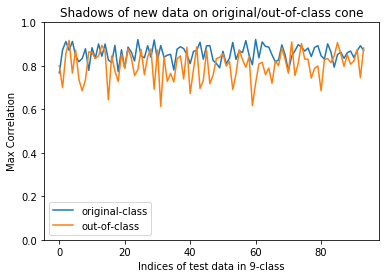

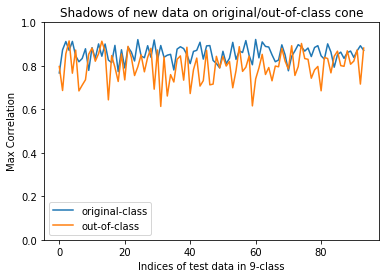

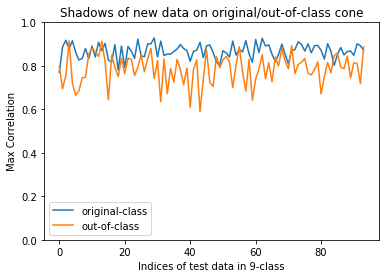

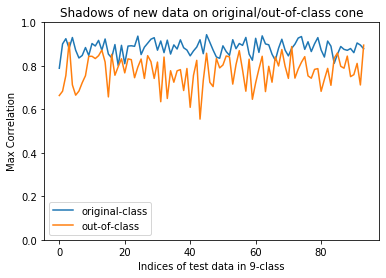

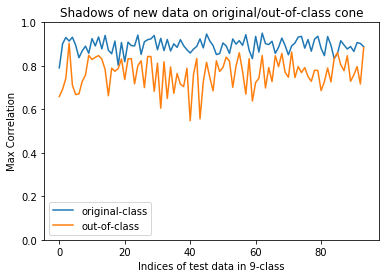

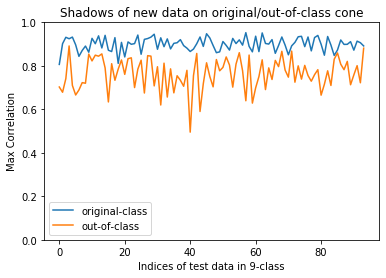

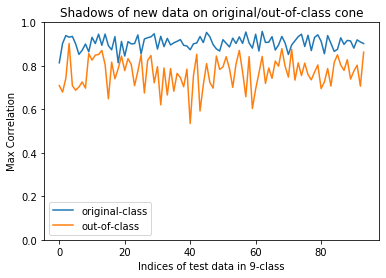

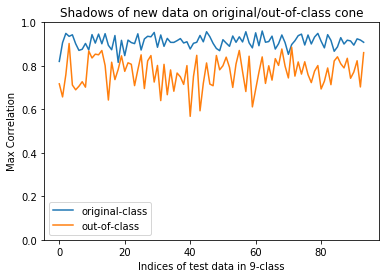

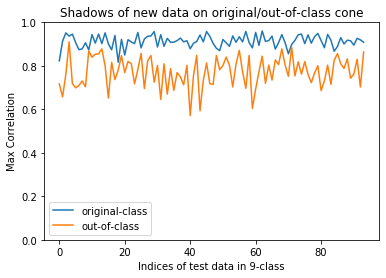

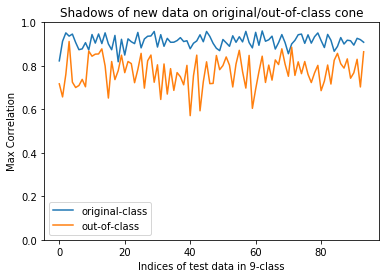

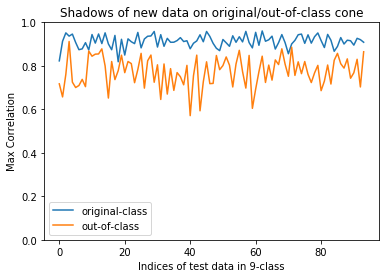

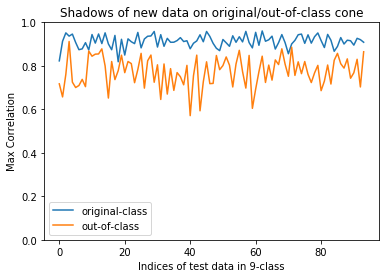

In [84]:
# 学習済みの凸錐から, 学習データにないクラスの係数を復元させ, 影の長さを取得
for ratio in opt["ratios"]:
    Cones = [];
    
    original_cone = create_cone_PCA(train_feature[train_label==9], 6.0, ratio);
    original_temp = restore_from_cone_PCA(original_cone, test_feature[test_label==9]);
    shadow = np.diag(cosine_similarity(test_feature[test_label == 9], original_temp));
    
    for i in range(9):
        cone =  create_cone_PCA(train_feature[train_label == i], 6.0, ratio);
        Cones.append(cone);
        
    restores = [];
    for i in range(9):
        temp = restore_from_cone_PCA(Cones[i], test_feature[test_label == 9]);
        restores.append(temp);
        
    CosArray = []
    for i in range(9):
        cos_array = cosine_similarity(test_feature, restores[i]);
        CosArray.append(np.diag(cos_array));
    
    CosArray = np.array(CosArray);
    error_max = np.max(CosArray, axis =0);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("Indices of test data in 9-class");
    ax.set_ylabel("Max Correlation");
    ax.set_ylim(0.0, 1.0);
    # ax.plot(accuracy);
    ax.set_title("Shadows of new data on original/out-of-class cone");
    ax.plot(shadow, label = "original-class");
    ax.plot(error_max, label = "out-of-class");
    ax.legend();
    fig.savefig("result/out_corr_"+str(ratio)+".png");
    
    
"""    
    predict_label = np.argmax(CosArray, axis = 0);
    precision = sum(preict_label == test_label)/test_label.shape[0];
    print("ratio="+str(ratio)+": Test precision: ", precision);
    accuracy.append(precision);
    
fig = plot.figure();
ax = fig.add_subplot(111);
ax.set_xlabel("Contribution rates of principal components");
ax.set_ylabel("Accuracy");
ax.set_ylim(0.0, 1.0);
# ax.plot(accuracy);
ax.set_title("Comprehensive cone restricted subspace method");
ax.plot(opt["ratios"], accuracy, label = "k="+str(param));
fig.savefig("result/pca_best.png")
"""

/home/tomoya/anaconda3/envs/thesis/lib/python3.7/site-packages/sporco/plot.py:673: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5548cfc7d0>)

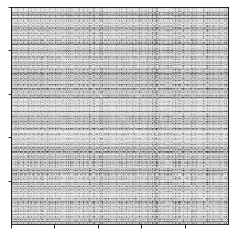

In [62]:
plot.imview(cos_array);

In [72]:
shadow.shape

(94,)